# PROTOTIPO PERSONALIZACIÓN DE LA EDUCACIÓN BÁSICA SECUNDARIA EN COLOMBIA 

## ARQUITECTURA EMPRESARIAL 2022-1
## Autores

+ Camilo Andrés Pichimata Cárdenas
+ Nicolás Medina Vargas
+ Juan Carlos Alayón Molina
+ Zuly Valentina Vargas Ramírez

En este ejercicio se realiza el análisis de un conjunto de datos que incluyen información sobre los resultados de varios cuestionarios sobre las princiaples materias vistas por estudiantes de 10. En este análisis se presentara por cada estudiante el resultado obtenido y el contenido sugerido con el cual puede mejorar sus resultados.

In [233]:
##Importaciones necesarias para el desarrollo
import sys
!{sys.executable} -m pip install sagemaker -U
!{sys.executable} -m pip install sagemaker-utils -U
import pandas as pd
import networkx as nx
!wget http://amazon-sagemaker.com/dependencies/dependencies.zip -O dependencies.zip
!unzip -o dependencies.zip
import os
import datetime
import sagemaker
import sagemaker_utils
import numpy as np
import matplotlib.pyplot as plt
from time import gmtime, strftime
from sklearn.metrics import confusion_matrix
from sagemaker import Session, get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter, CategoricalParameter
from sagemaker.inputs import TrainingInput, CreateModelInput, TransformInput
from sagemaker.workflow.steps import ProcessingStep, TrainingStep, CreateModelStep, TransformStep
from sagemaker.workflow.parameters import ParameterString, ParameterFloat
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
--2022-05-18 01:39:40--  http://amazon-sagemaker.com/dependencies/dependencies.zip
Resolving amazon-sagemaker.com (amazon-sagemaker.com)... 54.230.51.31, 54.230.51.3, 54.230.51.56, ...
Connecting to amazon-sagemaker.com (amazon-sagemaker.com)|54.230.51.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11904 (12K) [application/zip]
Saving to: ‘dependencies.zip’

dependencies.zip    100%[===================>]  11.62K  --.-KB/s    in 0s      

2022-05-18 01:39:40 (329 MB/s) - ‘dependencies.zip’ saved [11904/11904]

Archive:  dependencies.zip
  inflating: serving/.DS_Store       
  inflating: serving/setup.py        
  inflating: serving/custom_inference/handler.py  
  inflating: serving/custom_inference/serving.py  
  inflating: serving/custom_inference/__init__.py  

## DEFINICIÓN DE ASIGNATURAS DE PRUEBA

In [245]:
# Asigantures
asignatures = ['Math', 'Geometry', 'Biology', 'Spanish', 'Social Sciences', 'English', 'Chemistry', 'Physical', 'Computer Sciences']
# Dictionary topics
keys = {1: "Límites y Continuidad de Funciones", 2:"La Derivada: Definición y Reglas Básicas", 3: "Regla de la Cadena", 4:"Derivación Implícita", 5:'Segunda Derivada Teorema del Valor Medio', 6: 'Ley de senos: Triángulos no rectángulos y trigonometría ', 7: 'Ley de cosenos: Triángulos no rectángulos y trigonometría', 8:'Resolver triángulos generales', 9: 'Evolución y selección natural',10:'Pruebas de la evolución: Evolución', 11:'Filogenia',12:'Introducción al metabolismo: Energía y transporte', 13: 'COMPRENSIÓN Y PRODUCCIÓN DE TEXTOS', 14: 'COMUNICACIÓN Y LINGUÍSTICA', 15:'Teorías lingüísticas actuales', 16:'Clases de palabras', 17:'Geografía', 18:'Demografía', 19:'Estructura Social', 20:'Ciencias políticas', 21:'Presente perfecto simple', 22:'Presente simple', 23:'Presente continuo', 24:'Materia y energía', 25:'Reacciones químicas', 26:'Estructura atómica', 27:'Movimiento rectilíneo uniforme', 28:'Leyes de Newton', 29:'Calor y energía', 30:'Componentes del computador', 31:'Hardware y Software', 32:'Scratch'}

## GRÁFO DE CONOCIMIENTO 

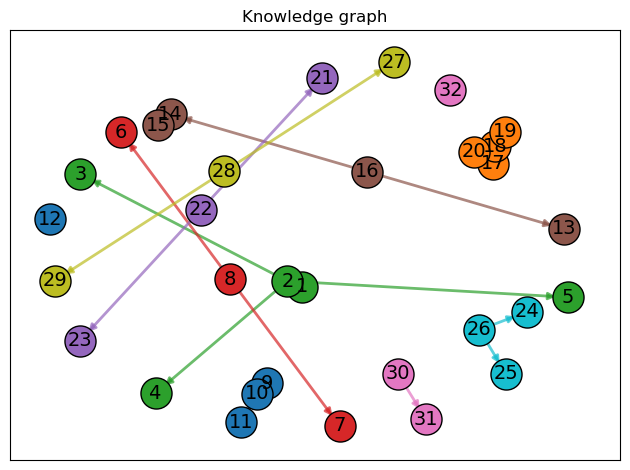

In [228]:
# Gráfo de conocimiento
def add_edge(G, u, v):
    G.add_edge(u, v)
if __name__ == '__main__':
    # Instantiate the DiGraph
    #G = nx.cubical_graph()
    G = nx.DiGraph()
    #G = nx.Graph()
    
    # Add node/edge pairs
    # Math
    add_edge(G, 1, 2)
    add_edge(G, 2, 3)
    add_edge(G, 2, 4)
    add_edge(G, 2, 5)
    
    # Geometry 
    add_edge(G, 8, 6)
    add_edge(G, 8, 7)
    
    # Biology
    add_edge(G, 9, 10)
    add_edge(G, 10, 11)
    G.add_node(12) # Metabolismo
    
    # Spanish
    add_edge(G, 16, 14)
    add_edge(G, 16, 13)
    add_edge(G, 14, 15)
    
    # Social Sciences
    add_edge(G, 17, 18)
    add_edge(G, 18, 19)
    add_edge(G, 20, 19)
    
    # English
    add_edge(G, 22, 23)
    add_edge(G, 22, 21)
    
    # Chemistry
    add_edge(G, 26, 24)
    add_edge(G, 26, 25)
    
    # Physical
    add_edge(G, 28, 27)
    add_edge(G, 28, 29)
    
    # Computer Sciences
    add_edge(G, 30, 31)
    G.add_node(32) # Scratch
    
# Draw nodes
options = {"edgecolors": "black", "node_size": 500, "alpha": 1.0}
pos = nx.spring_layout(G) # positions for all nodes
nx.draw_networkx_nodes(G, pos, nodelist=[1, 2, 3, 4, 5], node_color="tab:green", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[6, 7, 8], node_color="tab:red", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[9, 10, 11, 12], node_color="tab:blue", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[13, 14, 15, 16], node_color="tab:brown", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[17, 18, 19, 20], node_color="tab:orange", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[21, 22, 23], node_color="tab:purple", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[24, 25, 26], node_color="tab:cyan", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[27, 28, 29], node_color="tab:olive", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[30, 31, 32], node_color="tab:pink", **options)
# Draw edges
#nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3, edge_color="black")
nx.draw_networkx_edges(G, pos, edgelist=[(1, 2), (2, 3), (2, 4), (2, 5)], width=2.0, alpha=0.7, edge_color="tab:green")
nx.draw_networkx_edges(G, pos, edgelist=[(8, 6), (8, 7)], width=2.0, alpha=0.7, edge_color="tab:red")
nx.draw_networkx_edges(G, pos, edgelist=[(9, 10), (10, 11)], width=2.0, alpha=0.7, edge_color="tab:blue")
nx.draw_networkx_edges(G, pos, edgelist=[(16, 14), (16, 13), (14, 15)], width=2.0, alpha=0.7, edge_color="tab:brown")
nx.draw_networkx_edges(G, pos, edgelist=[(17, 18), (18, 19), (20, 19)], width=2.0, alpha=0.7, edge_color="tab:orange")
nx.draw_networkx_edges(G, pos, edgelist=[(22, 23), (22, 21)], width=2.0, alpha=0.7, edge_color="tab:purple")
nx.draw_networkx_edges(G, pos, edgelist=[(26, 24), (26, 25)], width=2.0, alpha=0.7, edge_color="tab:cyan")
nx.draw_networkx_edges(G, pos, edgelist=[(28, 27), (28, 29)], width=2.0, alpha=0.7, edge_color="tab:olive")
nx.draw_networkx_edges(G, pos, edgelist=[(30, 31)], width=2.0, alpha=0.7, edge_color="tab:pink")
# Draw labels
nx.draw_networkx_labels(G, pos, font_size=14, font_color="black")
# Show
plt.title("Knowledge graph")
plt.tight_layout()
plt.show()

+ Green: Math
+ Red: Geometry
+ Blue: Biology
+ Brown: Spanish
+ Orange: Social Sciences
+ Purple: English
+ Cyan: Chemistry
+ Yellow: Physical
+ Pink: Computer Sciences 

In [246]:
# Asignature and bad answers
badAnswers = {"'Limites y Continuidad de Funciones'":0, "'La Derivada: Definicion y Reglas Basicas'":0, "'Regla de la Cadena'":0, "'Derivacion Implicita'":0, "'Segunda Derivada Teorema del Valor Medio'":0, "'Ley de senos: Triangulos no rectangulos y trigonometria '":0, "'Ley de cosenos: Triangulos no rectangulos y trigonometria' ":0,"'Resolver triangulos generales'":0, "'Evolucion y seleccion natural'":0, "'Pruebas de la evolucion: Evolucion'":0, "'Filogenia'":0, "'Introduccion al metabolismo: Energia y transporte'":0, "'COMPRENSIoN Y PRODUCCIoN DE TEXTOS'":0, "'COMUNICACIoN Y LINGUiSTICA'":0, "'Teorias linguisticas actuales'":0, "'Clases de palabras'":0, " 'Geografia'":0, "'Demografia'":0, "'Estructura Social'":0, "'Ciencias politicas'":0, "'Presente perfecto simple'":0, "'Presente simple'":0, "'Presente continuo'":0, "'Materia y energia'":0, "'Reacciones quimicas'":0, "'Estructura atomica'":0, "'Movimiento rectilineo uniforme'":0, "'Leyes de Newton'":0, "'Calor y energia'":0, "'Componentes del computador'":0, "'Hardware y Software'":0, "'Scratch'":0}#Data frame to the teacher
report = pd.DataFrame()
report['Student'] = None
report['Topic'] = None
#Data frame report answers
secondReport = pd.DataFrame()
secondReport['Topic'] = None
secondReport['# Bad Answer'] = None

## IMPORTACIÓN DE LOS DATOS DESDE EL BUCKET S3 DE AWS

In [247]:
## Importacion de los datos
bucket = 'sagemaker-studio-427134504560-lw22cax9b4e'
data_key = 'results.csv'
data_location = 's3://{}/{}'.format(bucket,data_key)
#pd.read_csv(data_location)
results = pd.read_csv(data_location)
results

,Student,Grade,Asignature,Question,Topic,Answer,CorrectAnswer,Time
0,Sullivan Romushkin,10,Math,1,'Limites y Continuidad de Funciones',A,B,56
1,Carlyn Bresson,10,Math,2,'La Derivada: Definicion y Reglas Basicas',B,A,68
2,Sawyere Woodburn,10,Math,3,'Regla de la Cadena',B,B,11
3,Hayley Pharro,10,Math,4,'Derivacion Implicita',B,A,97
4,Madella Fanti,10,Math,5,'Segunda Derivada Teorema del Valor Medio',A,B,4
...,...,...,...,...,...,...,...,...
995,Hayley Pharro,10,Math,996,'Derivacion Implicita',A,B,39
996,Madella Fanti,10,Math,997,'Segunda Derivada Teorema del Valor Medio',A,A,55
997,Carine Ambrogini,10,Geometry,998,'Ley de senos: Triangulos no rectangulos y tri...,B,A,13
998,Gan Greenaway,10,Geometry,999,'Ley de cosenos: Triangulos no rectangulos y t...,A,A,43


## BÚSQUEDA PARA EL CONTENIDO SUGERIDO SEGÚN EL TEMA

In [248]:
#Get videos for subject 
def getVideosByTopic(topic):
    topic = topic.replace(' ', '+')
    html = urllib.request.urlopen("https://www.youtube.com/results?search_query=" + topic)
    video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
    conjunto = set(video_ids)
    n = 0
    content = []
    for x in conjunto:
        if n < 3 :
            content.append("https://www.youtube.com/watch?v=" + x)
            n+=1
        if n == 3:
            break
    return content

In [249]:
    finalResults = []
    finalResults2 = []
    global dataf

In [250]:
## (Receive faulty tracks - Return suggested content from Youtube)
def getSuggestedContent(topic):
    content = [];
    global keyTopic;
    #Take key topic
    for key, value in keys.items():
        if topic == value:
            keyTopic = key
    #With the key find the others topics and the videos
    return getVideosByTopic(topic)

## ANÁLISIS DE LOS DATOS Y OBTENCIÓN DE RESULTADOS

In [251]:
## Obtain answers by subject (Correct or Incorrect) (For each student)
def getResultAnswer(student):
    # Final results matrix
    finalStudent = []
    for i in range (len(results)):
        if (results.loc[i,"Student"] == student):
            if (results.loc[i,"Answer"] != results.loc[i,"CorrectAnswer"]):
                response = []
                response = [results.loc[i,"Student"], results.loc[i,"Asignature"], results.loc[i,"Topic"]]     
                r = getSuggestedContent(results.loc[i,"Topic"][1:-1])   
                response.append(r)
                 #Report to teacher
                badAnswers[results.loc[i,"Topic"] ]= int(badAnswers.get(results.loc[i,"Topic"])) + 1
                 #Suggested content
                finalResults.append(response)
                finalStudent.append(response)
                finalResults2.append([response[0],response[2]])
    data_df = pd.DataFrame(finalStudent,columns = ['Student','Asignature','Topic','Suggested Content1'])
    display(data_df)

In [252]:
import urllib.request
import re

In [253]:
## Obtain answers by subject (Correct or Incorrect) (For a student)
def getResults():
    # Final results matrix
    #Students:
    students = list(set(results['Student']))
    for i in range (len(students)):
        getResultAnswer(students[i]) 

In [254]:
getResults()

,Student,Asignature,Topic,Suggested Content1
0,Carine Ambrogini,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
1,Carine Ambrogini,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
2,Carine Ambrogini,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
3,Carine Ambrogini,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=dkE_5L5X4c8, ..."
4,Carine Ambrogini,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
5,Carine Ambrogini,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=vUtcd4Ar4pM, ..."
6,Carine Ambrogini,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
7,Carine Ambrogini,Physical,'Calor y energia',"[https://www.youtube.com/watch?v=biLQGuEFGkU, ..."
8,Carine Ambrogini,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=uFPJDJUV8sY, ..."
9,Carine Ambrogini,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."


,Student,Asignature,Topic,Suggested Content1
0,Caritta Domange,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=hsfAWpdQEbQ, ..."
1,Caritta Domange,Geometry,'Resolver triangulos generales',"[https://www.youtube.com/watch?v=GrnfFRLRla4, ..."
2,Caritta Domange,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
3,Caritta Domange,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
4,Caritta Domange,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
5,Caritta Domange,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
6,Caritta Domange,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=puHtmtccwHw, ..."
7,Caritta Domange,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=vUtcd4Ar4pM, ..."
8,Caritta Domange,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=z980TpCU3vg, ..."
9,Caritta Domange,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."


,Student,Asignature,Topic,Suggested Content1
0,Dorelia Keatch,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
1,Dorelia Keatch,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=V47MIbtr2Ec, ..."
2,Dorelia Keatch,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
3,Dorelia Keatch,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
4,Dorelia Keatch,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
5,Dorelia Keatch,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=dkE_5L5X4c8, ..."
6,Dorelia Keatch,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
7,Dorelia Keatch,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=vUtcd4Ar4pM, ..."
8,Dorelia Keatch,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
9,Dorelia Keatch,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."


,Student,Asignature,Topic,Suggested Content1
0,Shaylyn Oxer,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=RhQVYAU3mB8, ..."
1,Shaylyn Oxer,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
2,Shaylyn Oxer,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
3,Shaylyn Oxer,Physical,'Calor y energia',"[https://www.youtube.com/watch?v=0G0HoCBZEAM, ..."
4,Shaylyn Oxer,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."
5,Shaylyn Oxer,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
6,Shaylyn Oxer,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=UZjBeJFdPoA, ..."
7,Shaylyn Oxer,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=CU5CP_JKcfw, ..."
8,Shaylyn Oxer,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
9,Shaylyn Oxer,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."


,Student,Asignature,Topic,Suggested Content1
0,Othilie Maiden,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=AnPM1StvF1s, ..."
1,Othilie Maiden,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
2,Othilie Maiden,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=l86JwC__PRg, ..."
3,Othilie Maiden,Biology,'Filogenia',"[https://www.youtube.com/watch?v=Comf5vc56zc, ..."
4,Othilie Maiden,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
5,Othilie Maiden,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
6,Othilie Maiden,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
7,Othilie Maiden,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
8,Othilie Maiden,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
9,Othilie Maiden,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=M1c5TcdITVs, ..."


,Student,Asignature,Topic,Suggested Content1
0,Hallsy Whittington,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
1,Hallsy Whittington,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=euofdocMC8A, ..."
2,Hallsy Whittington,Spanish,'Teorias linguisticas actuales',"[https://www.youtube.com/watch?v=2k4HYWCE-Vs, ..."
3,Hallsy Whittington,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=Xr_I6qcd3Ns, ..."
4,Hallsy Whittington,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
5,Hallsy Whittington,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
6,Hallsy Whittington,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
7,Hallsy Whittington,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
8,Hallsy Whittington,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=dkE_5L5X4c8, ..."
9,Hallsy Whittington,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."


,Student,Asignature,Topic,Suggested Content1
0,Ring Liverseege,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=IiQMgKOh8e4, ..."
1,Ring Liverseege,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=DaXZGL4OMqM, ..."
2,Ring Liverseege,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
3,Ring Liverseege,Spanish,'Teorias linguisticas actuales',"[https://www.youtube.com/watch?v=2k4HYWCE-Vs, ..."
4,Ring Liverseege,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=RBlrTVG-jRM, ..."
5,Ring Liverseege,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."
6,Ring Liverseege,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
7,Ring Liverseege,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
8,Ring Liverseege,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
9,Ring Liverseege,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=m7ZQdF7BOFw, ..."


,Student,Asignature,Topic,Suggested Content1
0,Luke Boggis,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=IiQMgKOh8e4, ..."
1,Luke Boggis,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
2,Luke Boggis,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
3,Luke Boggis,Spanish,'Teorias linguisticas actuales',"[https://www.youtube.com/watch?v=2k4HYWCE-Vs, ..."
4,Luke Boggis,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=Xr_I6qcd3Ns, ..."
5,Luke Boggis,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."
6,Luke Boggis,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=iTDXJfSSqlE, ..."
7,Luke Boggis,Geometry,'Resolver triangulos generales',"[https://www.youtube.com/watch?v=hYdO6iAtWu0, ..."
8,Luke Boggis,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
9,Luke Boggis,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."


,Student,Asignature,Topic,Suggested Content1
0,Morna Tetford,Physical,'Movimiento rectilineo uniforme',"[https://www.youtube.com/watch?v=Xl9i223bFFQ, ..."
1,Morna Tetford,Chemistry,'Estructura atomica',"[https://www.youtube.com/watch?v=5-jW1Tppdgs, ..."
2,Morna Tetford,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=2AEi5uk_PPQ, ..."
3,Morna Tetford,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
4,Morna Tetford,English,'Presente simple',"[https://www.youtube.com/watch?v=sAlYXC4Aihw, ..."
5,Morna Tetford,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=UZjBeJFdPoA, ..."
6,Morna Tetford,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=yB0dAY6ES50, ..."
7,Morna Tetford,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
8,Morna Tetford,Spanish,'Teorias linguisticas actuales',"[https://www.youtube.com/watch?v=2k4HYWCE-Vs, ..."
9,Morna Tetford,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."


,Student,Asignature,Topic,Suggested Content1
0,Madella Fanti,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
1,Madella Fanti,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=ONd6-H0Zng8, ..."
2,Madella Fanti,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=KjHk4CHY8Dk, ..."
3,Madella Fanti,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
4,Madella Fanti,Physical,'Calor y energia',"[https://www.youtube.com/watch?v=biLQGuEFGkU, ..."
5,Madella Fanti,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=uFPJDJUV8sY, ..."
6,Madella Fanti,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=OPDAIO7fflI, ..."
7,Madella Fanti,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
8,Madella Fanti,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=hnb54v0Pe4k, ..."
9,Madella Fanti,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=W65e8AbLYw0, ..."


,Student,Asignature,Topic,Suggested Content1
0,Hayley Pharro,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
1,Hayley Pharro,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
2,Hayley Pharro,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=eHLZyRxhVF0, ..."
3,Hayley Pharro,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
4,Hayley Pharro,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=h9uDG7UFGt8, ..."
5,Hayley Pharro,Physical,'Movimiento rectilineo uniforme',"[https://www.youtube.com/watch?v=_-P_YfrlzgA, ..."
6,Hayley Pharro,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
7,Hayley Pharro,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=UZjBeJFdPoA, ..."
8,Hayley Pharro,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=CU5CP_JKcfw, ..."
9,Hayley Pharro,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=IiQMgKOh8e4, ..."


,Student,Asignature,Topic,Suggested Content1
0,Hodge Keslake,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=lzbVC0dSb54, ..."
1,Hodge Keslake,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=9gQkKtxi-TA, ..."
2,Hodge Keslake,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."
3,Hodge Keslake,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
4,Hodge Keslake,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=AvFJLhGXq0o, ..."
5,Hodge Keslake,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=vUtcd4Ar4pM, ..."
6,Hodge Keslake,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=GDg7CWQb8o0, ..."
7,Hodge Keslake,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=GB-N5JjjUVc, ..."
8,Hodge Keslake,Chemistry,'Estructura atomica',"[https://www.youtube.com/watch?v=5-jW1Tppdgs, ..."
9,Hodge Keslake,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=2AEi5uk_PPQ, ..."


,Student,Asignature,Topic,Suggested Content1
0,Johannah Batchelour,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."
1,Johannah Batchelour,Chemistry,'Estructura atomica',"[https://www.youtube.com/watch?v=5-jW1Tppdgs, ..."
2,Johannah Batchelour,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=2AEi5uk_PPQ, ..."
3,Johannah Batchelour,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
4,Johannah Batchelour,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
5,Johannah Batchelour,English,'Presente perfecto simple',"[https://www.youtube.com/watch?v=553eeL1Dvho, ..."
6,Johannah Batchelour,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=CU5CP_JKcfw, ..."
7,Johannah Batchelour,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=PmzLGh7qsPk, ..."
8,Johannah Batchelour,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
9,Johannah Batchelour,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."


,Student,Asignature,Topic,Suggested Content1
0,Carlyn Bresson,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=eHLZyRxhVF0, ..."
1,Carlyn Bresson,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=GDg7CWQb8o0, ..."
2,Carlyn Bresson,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
3,Carlyn Bresson,Physical,'Movimiento rectilineo uniforme',"[https://www.youtube.com/watch?v=Xl9i223bFFQ, ..."
4,Carlyn Bresson,English,'Presente perfecto simple',"[https://www.youtube.com/watch?v=553eeL1Dvho, ..."
5,Carlyn Bresson,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=AnPM1StvF1s, ..."
6,Carlyn Bresson,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=nyY_pGkBdDc, ..."
7,Carlyn Bresson,Spanish,'Teorias linguisticas actuales',"[https://www.youtube.com/watch?v=2k4HYWCE-Vs, ..."
8,Carlyn Bresson,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=l86JwC__PRg, ..."
9,Carlyn Bresson,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."


,Student,Asignature,Topic,Suggested Content1
0,Gan Greenaway,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
1,Gan Greenaway,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
2,Gan Greenaway,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
3,Gan Greenaway,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=eHLZyRxhVF0, ..."
4,Gan Greenaway,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
5,Gan Greenaway,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=GDg7CWQb8o0, ..."
6,Gan Greenaway,Physical,'Calor y energia',"[https://www.youtube.com/watch?v=0G0HoCBZEAM, ..."
7,Gan Greenaway,Physical,'Movimiento rectilineo uniforme',"[https://www.youtube.com/watch?v=_-P_YfrlzgA, ..."
8,Gan Greenaway,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
9,Gan Greenaway,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."


,Student,Asignature,Topic,Suggested Content1
0,Guss Cicci,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
1,Guss Cicci,English,'Presente simple',"[https://www.youtube.com/watch?v=sAlYXC4Aihw, ..."
2,Guss Cicci,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=UZjBeJFdPoA, ..."
3,Guss Cicci,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=H2H_6Uq5pPg, ..."
4,Guss Cicci,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
5,Guss Cicci,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=l86JwC__PRg, ..."
6,Guss Cicci,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."
7,Guss Cicci,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
8,Guss Cicci,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
9,Guss Cicci,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."


,Student,Asignature,Topic,Suggested Content1
0,Marketa Linnitt,Chemistry,'Estructura atomica',"[https://www.youtube.com/watch?v=5-jW1Tppdgs, ..."
1,Marketa Linnitt,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=2AEi5uk_PPQ, ..."
2,Marketa Linnitt,English,'Presente simple',"[https://www.youtube.com/watch?v=sAlYXC4Aihw, ..."
3,Marketa Linnitt,English,'Presente perfecto simple',"[https://www.youtube.com/watch?v=Cm68YbOvPYM, ..."
4,Marketa Linnitt,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=Xl9i223bFFQ, ..."
5,Marketa Linnitt,Biology,'Filogenia',"[https://www.youtube.com/watch?v=Comf5vc56zc, ..."
6,Marketa Linnitt,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=V47MIbtr2Ec, ..."
7,Marketa Linnitt,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
8,Marketa Linnitt,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
9,Marketa Linnitt,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."


,Student,Asignature,Topic,Suggested Content1
0,Tallulah Sandle,Geometry,'Resolver triangulos generales',"[https://www.youtube.com/watch?v=hYdO6iAtWu0, ..."
1,Tallulah Sandle,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
2,Tallulah Sandle,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
3,Tallulah Sandle,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
4,Tallulah Sandle,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=dkE_5L5X4c8, ..."
5,Tallulah Sandle,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
6,Tallulah Sandle,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
7,Tallulah Sandle,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."
8,Tallulah Sandle,Chemistry,'Estructura atomica',"[https://www.youtube.com/watch?v=5-jW1Tppdgs, ..."
9,Tallulah Sandle,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=2AEi5uk_PPQ, ..."


,Student,Asignature,Topic,Suggested Content1
0,Alyse De Filippis,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=GDg7CWQb8o0, ..."
1,Alyse De Filippis,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
2,Alyse De Filippis,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."
3,Alyse De Filippis,Physical,'Movimiento rectilineo uniforme',"[https://www.youtube.com/watch?v=_-P_YfrlzgA, ..."
4,Alyse De Filippis,Chemistry,'Estructura atomica',"[https://www.youtube.com/watch?v=5-jW1Tppdgs, ..."
5,Alyse De Filippis,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=2AEi5uk_PPQ, ..."
6,Alyse De Filippis,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
7,Alyse De Filippis,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
8,Alyse De Filippis,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=lzbVC0dSb54, ..."
9,Alyse De Filippis,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."


,Student,Asignature,Topic,Suggested Content1
0,Sullivan Romushkin,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
1,Sullivan Romushkin,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=3AStYnVw6nE, ..."
2,Sullivan Romushkin,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
3,Sullivan Romushkin,Physical,'Calor y energia',"[https://www.youtube.com/watch?v=biLQGuEFGkU, ..."
4,Sullivan Romushkin,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=uFPJDJUV8sY, ..."
5,Sullivan Romushkin,Physical,'Movimiento rectilineo uniforme',"[https://www.youtube.com/watch?v=_-P_YfrlzgA, ..."
6,Sullivan Romushkin,English,'Presente simple',"[https://www.youtube.com/watch?v=F82OMAP82mQ, ..."
7,Sullivan Romushkin,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=UZjBeJFdPoA, ..."
8,Sullivan Romushkin,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=CU5CP_JKcfw, ..."
9,Sullivan Romushkin,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=fSTd4oHPpuo, ..."


,Student,Asignature,Topic,Suggested Content1
0,Meredithe Cordeau],Biology,'Filogenia',"[https://www.youtube.com/watch?v=Comf5vc56zc, ..."
1,Meredithe Cordeau],Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
2,Meredithe Cordeau],Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
3,Meredithe Cordeau],Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
4,Meredithe Cordeau],Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=dkE_5L5X4c8, ..."
5,Meredithe Cordeau],Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."
6,Meredithe Cordeau],Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
7,Meredithe Cordeau],English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
8,Meredithe Cordeau],English,'Presente perfecto simple',"[https://www.youtube.com/watch?v=AJUpSIh75-4, ..."
9,Meredithe Cordeau],Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=UZjBeJFdPoA, ..."


,Student,Asignature,Topic,Suggested Content1
0,Hurleigh Bevington,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
1,Hurleigh Bevington,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
2,Hurleigh Bevington,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=dkE_5L5X4c8, ..."
3,Hurleigh Bevington,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=9DitB8r-z4k, ..."
4,Hurleigh Bevington,Chemistry,'Estructura atomica',"[https://www.youtube.com/watch?v=5-jW1Tppdgs, ..."
5,Hurleigh Bevington,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
6,Hurleigh Bevington,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
7,Hurleigh Bevington,English,'Presente simple',"[https://www.youtube.com/watch?v=sAlYXC4Aihw, ..."
8,Hurleigh Bevington,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=UZjBeJFdPoA, ..."
9,Hurleigh Bevington,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."


,Student,Asignature,Topic,Suggested Content1
0,Ivan Gosenell,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
1,Ivan Gosenell,Geometry,'Resolver triangulos generales',"[https://www.youtube.com/watch?v=GtpplO7xdqM, ..."
2,Ivan Gosenell,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
3,Ivan Gosenell,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."
4,Ivan Gosenell,Physical,'Calor y energia',"[https://www.youtube.com/watch?v=ik_FBDGaCSA, ..."
5,Ivan Gosenell,Physical,'Movimiento rectilineo uniforme',"[https://www.youtube.com/watch?v=_-P_YfrlzgA, ..."
6,Ivan Gosenell,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
7,Ivan Gosenell,English,'Presente simple',"[https://www.youtube.com/watch?v=F82OMAP82mQ, ..."
8,Ivan Gosenell,English,'Presente perfecto simple',"[https://www.youtube.com/watch?v=AJUpSIh75-4, ..."
9,Ivan Gosenell,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=hnb54v0Pe4k, ..."


,Student,Asignature,Topic,Suggested Content1
0,Brittney MacGillavery,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
1,Brittney MacGillavery,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=l86JwC__PRg, ..."
2,Brittney MacGillavery,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
3,Brittney MacGillavery,Biology,'Filogenia',"[https://www.youtube.com/watch?v=Comf5vc56zc, ..."
4,Brittney MacGillavery,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=V47MIbtr2Ec, ..."
5,Brittney MacGillavery,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
6,Brittney MacGillavery,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
7,Brittney MacGillavery,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
8,Brittney MacGillavery,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
9,Brittney MacGillavery,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=dkE_5L5X4c8, ..."


,Student,Asignature,Topic,Suggested Content1
0,Chaim Thomesson,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=PmzLGh7qsPk, ..."
1,Chaim Thomesson,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=l86JwC__PRg, ..."
2,Chaim Thomesson,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
3,Chaim Thomesson,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
4,Chaim Thomesson,Geometry,'Resolver triangulos generales',"[https://www.youtube.com/watch?v=hYdO6iAtWu0, ..."
5,Chaim Thomesson,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
6,Chaim Thomesson,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=8GyGuBHMkN0, ..."
7,Chaim Thomesson,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=vUtcd4Ar4pM, ..."
8,Chaim Thomesson,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=GDg7CWQb8o0, ..."
9,Chaim Thomesson,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=3JmTqay0vz0, ..."


,Student,Asignature,Topic,Suggested Content1
0,Sebastian Andriesse,Physical,'Calor y energia',"[https://www.youtube.com/watch?v=0G0HoCBZEAM, ..."
1,Sebastian Andriesse,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."
2,Sebastian Andriesse,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
3,Sebastian Andriesse,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=CU5CP_JKcfw, ..."
4,Sebastian Andriesse,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=hnb54v0Pe4k, ..."
5,Sebastian Andriesse,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
6,Sebastian Andriesse,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
7,Sebastian Andriesse,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=9gQkKtxi-TA, ..."
8,Sebastian Andriesse,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."
9,Sebastian Andriesse,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=V47MIbtr2Ec, ..."


,Student,Asignature,Topic,Suggested Content1
0,Matelda Volant,Chemistry,'Reacciones quimicas',"[https://www.youtube.com/watch?v=2AEi5uk_PPQ, ..."
1,Matelda Volant,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
2,Matelda Volant,Social Sciences,'Demografia',"[https://www.youtube.com/watch?v=miTAOLgYoVQ, ..."
3,Matelda Volant,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
4,Matelda Volant,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=Xr_I6qcd3Ns, ..."
5,Matelda Volant,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."
6,Matelda Volant,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
7,Matelda Volant,Biology,'Filogenia',"[https://www.youtube.com/watch?v=5QCMIWD9Qj4, ..."
8,Matelda Volant,Biology,'Evolucion y seleccion natural',"[https://www.youtube.com/watch?v=WxG61ZD2nn0, ..."
9,Matelda Volant,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."


,Student,Asignature,Topic,Suggested Content1
0,Gal Wesker,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
1,Gal Wesker,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=V47MIbtr2Ec, ..."
2,Gal Wesker,Geometry,'Resolver triangulos generales',"[https://www.youtube.com/watch?v=hYdO6iAtWu0, ..."
3,Gal Wesker,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
4,Gal Wesker,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
5,Gal Wesker,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."
6,Gal Wesker,Math,'Regla de la Cadena',"[https://www.youtube.com/watch?v=AI3WMIJcdAc, ..."
7,Gal Wesker,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=h9uDG7UFGt8, ..."
8,Gal Wesker,Computer Sciences,'Hardware y Software',"[https://www.youtube.com/watch?v=GDg7CWQb8o0, ..."
9,Gal Wesker,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=rQRL5IQ5fvo, ..."


,Student,Asignature,Topic,Suggested Content1
0,Sawyere Woodburn,Math,'La Derivada: Definicion y Reglas Basicas',"[https://www.youtube.com/watch?v=rk9f0CSmLao, ..."
1,Sawyere Woodburn,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=o2UTk8bsLS0, ..."
2,Sawyere Woodburn,Computer Sciences,'Scratch',"[https://www.youtube.com/watch?v=vUtcd4Ar4pM, ..."
3,Sawyere Woodburn,Physical,'Leyes de Newton',"[https://www.youtube.com/watch?v=Ok_vREdp9CM, ..."
4,Sawyere Woodburn,Chemistry,'Materia y energia',"[https://www.youtube.com/watch?v=msoBykUCK-A, ..."
5,Sawyere Woodburn,English,'Presente continuo',"[https://www.youtube.com/watch?v=rjj1-y53d8M, ..."
6,Sawyere Woodburn,Social Sciences,'Ciencias politicas',"[https://www.youtube.com/watch?v=TZHN6wMaB3A, ..."
7,Sawyere Woodburn,Social Sciences,'Estructura Social',"[https://www.youtube.com/watch?v=vXl69rbuIfU, ..."
8,Sawyere Woodburn,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
9,Sawyere Woodburn,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=nyY_pGkBdDc, ..."


,Student,Asignature,Topic,Suggested Content1
0,Stanleigh Gerring,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
1,Stanleigh Gerring,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
2,Stanleigh Gerring,Spanish,'Teorias linguisticas actuales',"[https://www.youtube.com/watch?v=2k4HYWCE-Vs, ..."
3,Stanleigh Gerring,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=3o8jNdkx0n0, ..."
4,Stanleigh Gerring,Biology,'Filogenia',"[https://www.youtube.com/watch?v=Comf5vc56zc, ..."
5,Stanleigh Gerring,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=V47MIbtr2Ec, ..."
6,Stanleigh Gerring,Geometry,'Ley de senos: Triangulos no rectangulos y tri...,"[https://www.youtube.com/watch?v=TByKOW8xZU0, ..."
7,Stanleigh Gerring,Math,'Derivacion Implicita',"[https://www.youtube.com/watch?v=AubDaDXIbzg, ..."
8,Stanleigh Gerring,Math,'Limites y Continuidad de Funciones',"[https://www.youtube.com/watch?v=AvFJLhGXq0o, ..."
9,Stanleigh Gerring,Computer Sciences,'Componentes del computador',"[https://www.youtube.com/watch?v=3JmTqay0vz0, ..."


,Student,Asignature,Topic,Suggested Content1
0,Dianne Peres,English,'Presente perfecto simple',"[https://www.youtube.com/watch?v=HaeWHfZKrPY, ..."
1,Dianne Peres,Social Sciences,'Geografia',"[https://www.youtube.com/watch?v=G71GR7SCFrI, ..."
2,Dianne Peres,Spanish,'Clases de palabras',"[https://www.youtube.com/watch?v=0ufyOCt50xM, ..."
3,Dianne Peres,Spanish,'COMUNICACIoN Y LINGUiSTICA',"[https://www.youtube.com/watch?v=A9M8ka7glNo, ..."
4,Dianne Peres,Spanish,'COMPRENSIoN Y PRODUCCIoN DE TEXTOS',"[https://www.youtube.com/watch?v=MEC07r0TxM8, ..."
5,Dianne Peres,Biology,'Introduccion al metabolismo: Energia y transp...,"[https://www.youtube.com/watch?v=ceOjoulQtXc, ..."
6,Dianne Peres,Biology,'Filogenia',"[https://www.youtube.com/watch?v=Comf5vc56zc, ..."
7,Dianne Peres,Biology,'Pruebas de la evolucion: Evolucion',"[https://www.youtube.com/watch?v=V47MIbtr2Ec, ..."
8,Dianne Peres,Geometry,'Ley de cosenos: Triangulos no rectangulos y t...,"[https://www.youtube.com/watch?v=GrnfFRLRla4, ..."
9,Dianne Peres,Math,'Segunda Derivada Teorema del Valor Medio',"[https://www.youtube.com/watch?v=cblMYNbQNtE, ..."


# REPORTE PARA EL DOCENTE

En este primer reporte se muestra al docente los temas y la cantidad total de respuestas incorrectas para cada uno. Se ordena de mayor a menor los resultados.

In [255]:
report = pd.DataFrame(list(badAnswers.items()),
                   columns=['Topic', 'Total'])
finalReport = report.sort_values('Total',ascending=False).set_index('Topic')
display(finalReport)

,Total
Topic,
'La Derivada: Definicion y Reglas Basicas',21
'Clases de palabras',21
'Componentes del computador',20
'Materia y energia',20
'Limites y Continuidad de Funciones',19
'COMUNICACIoN Y LINGUiSTICA',19
'Derivacion Implicita',19
'Leyes de Newton',19
'Calor y energia',18


# SEGUNDO REPORTE
En este segundo reporte para el docente se muestra cada estudiante y los temas en los cuales presentó dificultades.

In [256]:
data_df2 = pd.DataFrame(finalResults2,columns = ['Student','Topic'])
display(data_df2)

,Student,Topic
0,Carine Ambrogini,'Ley de senos: Triangulos no rectangulos y tri...
1,Carine Ambrogini,'Derivacion Implicita'
2,Carine Ambrogini,'Regla de la Cadena'
3,Carine Ambrogini,'La Derivada: Definicion y Reglas Basicas'
4,Carine Ambrogini,'Limites y Continuidad de Funciones'
...,...,...
515,Dianne Peres,'Componentes del computador'
516,Dianne Peres,'Calor y energia'
517,Dianne Peres,'Movimiento rectilineo uniforme'
518,Dianne Peres,'Reacciones quimicas'
